# 0910 New_train 탐색에서 hold_d와 hist_d뿐만 아니라 after_d와 hist_d와도 관계가 있음을 알 수 있었다.
## 물론 완벽한 선형관계는 아니었지만 전체적으로 hist_d가 증가할 수록 after_d가 증가하는 패턴을 보였다.
## hold_d전체를 hist_d와의 관계를 보면 무조건 1 x hist_d + after_d이기에 after_d와 hist_d와의 관계가 모델에 크게 반영이 되지 않을 수 있다.
## 그러므로 after_d를 target으로 하는 모델을 생성한다

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [4]:
train=pd.read_csv("train_0909.csv")
test=pd.read_csv("test_0909.csv")

# train은 hold_d 가 hist_d보다 큰 경우에만 사용한다
train['after_d']=train['hold_d']-train['hist_d']
train=train[train['after_d']>0]
train

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,...,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,hist_d,after_d
0,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20190424,174,1,4,5,5,2,3,...,7,3,99,1099,1670.0,9769500.0,5000.0,5850.0,170,4
1,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20190924,71,1,4,5,5,2,3,...,13,3,99,2098,7999.0,19517560.0,500.0,2440.0,67,4
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A042510,20190524,241,1,6,4,4,2,5,...,13,3,99,1931,1100.0,3789500.0,500.0,3445.0,150,91
3,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A001045,20190617,164,1,6,4,4,2,5,...,2,99,99,2311,23.0,1271900.0,5000.0,55300.0,135,29
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A166090,20191030,85,1,6,4,4,2,5,...,13,2,2,349,200.0,3400000.0,500.0,17000.0,43,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16033,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,A067630,20191030,72,2,2,99,6,2,2,...,5,1,2,107,852.0,29394000.0,500.0,34500.0,43,29
16034,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,A028300,20191028,123,2,2,99,6,2,2,...,10,1,2,151,264.0,34584000.0,500.0,131000.0,45,78
16035,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A100700,20191120,38,1,6,0,5,2,5,...,10,2,99,556,20.0,65600.0,100.0,3280.0,28,10
16036,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A026960,20190701,262,1,6,0,5,2,5,...,7,1,1,59,2.0,38100.0,500.0,19050.0,125,137


In [5]:
test

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,...,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,...,5,8,4,1,1,28,300.0,3945000.0,5000.0,13150.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,...,5,8,10,3,99,1582,198.0,2524500.0,500.0,12750.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,...,5,8,13,2,99,654,138.0,4291800.0,500.0,31100.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,...,5,8,13,3,99,2066,2972.0,6716720.0,500.0,2260.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,...,5,8,13,1,2,169,10.0,464500.0,100.0,46450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,1,6,0,5,...,5,2,2,1,1,10,1.0,198500.0,500.0,198500.0
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,1,6,0,5,...,5,2,2,99,99,2322,50.0,372000.0,5000.0,7440.0
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,1,4,4,2,...,3,8,14,3,99,2269,75057.0,3677793.0,100.0,49.0
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,1,4,4,2,...,3,8,8,2,99,469,96.0,11424000.0,2500.0,119000.0


In [6]:
train.describe()

,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,...,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,hist_d,after_d
count,1.528300e+04,15283.000000,15283.00000,15283.000000,15283.000000,15283.000000,15283.000000,15283.000000,15283.000000,15283.000000,...,15283.000000,15283.000000,15283.000000,15283.000000,15283.000000,1.528300e+04,15283.000000,1.528300e+04,15283.000000,15283.000000
mean,2.019089e+07,142.760387,1.33305,5.255513,24.773801,3.073480,2.042924,4.885297,4.637702,3.307989,...,9.041353,7.271609,65.756658,920.421645,495.585356,3.249844e+06,1182.235163,3.228739e+04,76.439835,66.320552
std,3.326480e+02,109.426830,0.47132,1.941111,39.742124,1.563231,0.468469,1.791478,2.093217,0.739773,...,3.513411,21.559882,46.246370,765.526048,2943.140868,1.335093e+07,1651.368875,6.737242e+04,69.471999,65.005923
min,2.019010e+07,2.000000,1.00000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.570000e+02,0.000000,1.000000e+02,1.000000,1.000000
25%,2.019062e+07,46.000000,1.00000,4.000000,3.000000,2.000000,2.000000,3.000000,3.000000,3.000000,...,6.000000,2.000000,2.000000,218.000000,8.000000,1.199810e+05,500.000000,4.200000e+03,17.000000,12.000000
50%,2.019102e+07,124.000000,1.00000,5.000000,4.000000,3.000000,2.000000,5.000000,4.000000,3.000000,...,10.000000,2.000000,99.000000,683.000000,50.000000,6.075000e+05,500.000000,9.590000e+03,49.000000,45.000000
75%,2.019120e+07,222.000000,2.00000,7.000000,5.000000,4.000000,2.000000,6.000000,5.000000,4.000000,...,12.000000,3.000000,99.000000,1535.000000,228.000000,2.184880e+06,500.000000,3.047500e+04,131.000000,105.000000
max,2.019123e+07,493.000000,2.00000,9.000000,99.000000,6.000000,15.000000,9.000000,9.000000,6.000000,...,14.000000,99.000000,99.000000,3044.000000,233281.000000,6.951774e+08,5000.000000,1.430000e+06,246.000000,247.000000


# 기본적인 전처리

## 서열이 있는 명목형의 경우에는 그에 맞게 labeling을 조정해준다
## 성별과 같이 경우가 2가지인 경우에는 0,1로 맞춰준다
## 위와 같은 경우가 아니면 그대로 labeling을 최대한 사용한다.


In [7]:
# train전처리
data=train.copy()

##############################################################3###################################3######
#########################   iem   #######################################################################


# 성별 0,1로
data['sex_dit_cd']=data['sex_dit_cd']-1


# 투자성향(ivs_icn_cd)
#  99는 0으로, 나머지는 그냥 label 유지
ivs_icn_cd_na=(data['ivs_icn_cd']==99).astype(int)        #99인 경우만 1으로 -> 1-na해서 곱해주면 99가 0된다
data['ivs_icn_cd']=data['ivs_icn_cd']*(1-ivs_icn_cd_na)


# 고객 등급 
# 9(등급 미정의)와 99(결측치)는 굳이 영향을 고려하지 않는것이 좋다고 판단된다 => 0으로 변환해준다 
# 나머지는 서열 순으로 되어있으므로 그대로둔다
tco_na=(data['tco_cus_grd_cd']>=9).astype(int)
data['tco_cus_grd_cd']=data['tco_cus_grd_cd']*(1-tco_na)


# 주거래 상품(mrz_pdt_tp_sgm_cd)
# 주로 국내주식 과 해외주식이다. => 국내주식과 해외주식을 나타내는 dummy를 만들고 OW는 00처리한다
data['mrz_pdt_tp_sgm_cd_2']=(data['mrz_pdt_tp_sgm_cd']==2).astype(int) # 국내주식 dummy
data['mrz_pdt_tp_sgm_cd_3']=(data['mrz_pdt_tp_sgm_cd']==3).astype(int) # 국외주식 dummy

data=data.drop(['mrz_pdt_tp_sgm_cd'],axis=1)  # dummy화 했으므로 기존의 변수는 제거한다


# LIFE STAGE, 주거래 업종(mrz_btp)는 그대로 둔다


##############################################################3###################################3######
#########################   iem   #######################################################################


# 시가 총액 
# 규모에 맞게 소,중,대 를(1,2,3)으로 labeling해준다, 또한 99(결측)을 제거한다
# 99를 4로 만들고 4-column 를 하면 위의 순서로 배치된다. 
data['mkt_pr_tal_scl_tp_cd']=data['mkt_pr_tal_scl_tp_cd']-95*(data['mkt_pr_tal_scl_tp_cd']==99).astype(int)
data['mkt_pr_tal_scl_tp_cd']=4-data['mkt_pr_tal_scl_tp_cd']

# 시장구분
# 코스피, 코스닥을 (1,2)로, 기타를 0으로 labeling한다
data['stk_dit_cd']=data['stk_dit_cd']-96*(data['stk_dit_cd']==99).astype(int)
data['stk_dit_cd']=3-data['stk_dit_cd']


# 기업명은 시가총액규모 - 시장구분 - 종목업종 순으로 labeling 되어있으므로 그대로 사용한다
# 종목업종(btp_cfc_cd)역시 서열이 없으므로 그대로 사용한다


##############################################################3###################################3######
#########################   hist   #######################################################################
# hist는 수치적의미 위주이므로 그대로 사용한다


########################################################################################################
# 다시 train으로 복귀
train=data.copy()

In [8]:
# test전처리
data=test.copy()

##############################################################3###################################3######
#########################   iem   #######################################################################


# 성별 0,1로
data['sex_dit_cd']=data['sex_dit_cd']-1


# 투자성향(ivs_icn_cd)
#  99는 0으로, 나머지는 그냥 label 유지
ivs_icn_cd_na=(data['ivs_icn_cd']==99).astype(int)        #99인 경우만 1으로 -> 1-na해서 곱해주면 99가 0된다
data['ivs_icn_cd']=data['ivs_icn_cd']*(1-ivs_icn_cd_na)


# 고객 등급 
# 9(등급 미정의)와 99(결측치)는 굳이 영향을 고려하지 않는것이 좋다고 판단된다 => 0으로 변환해준다 
# 나머지는 서열 순으로 되어있으므로 그대로둔다
tco_na=(data['tco_cus_grd_cd']>=9).astype(int)
data['tco_cus_grd_cd']=data['tco_cus_grd_cd']*(1-tco_na)


# 주거래 상품(mrz_pdt_tp_sgm_cd)
# 주로 국내주식 과 해외주식이다. => 국내주식과 해외주식을 나타내는 dummy를 만들고 OW는 00처리한다
data['mrz_pdt_tp_sgm_cd_2']=(data['mrz_pdt_tp_sgm_cd']==2).astype(int) # 국내주식 dummy
data['mrz_pdt_tp_sgm_cd_3']=(data['mrz_pdt_tp_sgm_cd']==3).astype(int) # 국외주식 dummy

data=data.drop(['mrz_pdt_tp_sgm_cd'],axis=1)  # dummy화 했으므로 기존의 변수는 제거한다


# LIFE STAGE, 주거래 업종(mrz_btp)는 그대로 둔다


##############################################################3###################################3######
#########################   iem   #######################################################################


# 시가 총액 
# 규모에 맞게 소,중,대 를(1,2,3)으로 labeling해준다, 또한 99(결측)을 제거한다
# 99를 4로 만들고 4-column 를 하면 위의 순서로 배치된다. 
data['mkt_pr_tal_scl_tp_cd']=data['mkt_pr_tal_scl_tp_cd']-95*(data['mkt_pr_tal_scl_tp_cd']==99).astype(int)
data['mkt_pr_tal_scl_tp_cd']=4-data['mkt_pr_tal_scl_tp_cd']

# 시장구분
# 코스피, 코스닥을 (1,2)로, 기타를 0으로 labeling한다
data['stk_dit_cd']=data['stk_dit_cd']-96*(data['stk_dit_cd']==99).astype(int)
data['stk_dit_cd']=3-data['stk_dit_cd']


# 기업명은 시가총액규모 - 시장구분 - 종목업종 순으로 labeling 되어있으므로 그대로 사용한다
# 종목업종(btp_cfc_cd)역시 서열이 없으므로 그대로 사용한다


##############################################################3###################################3######
#########################   hist   #######################################################################
# hist는 수치적의미 위주이므로 그대로 사용한다


########################################################################################################
# 다시 train으로 복귀
test=data.copy()

# 가볍게 correlation을 본다

In [9]:
train.columns

Index(['act_id', 'iem_cd', 'byn_dt', 'hold_d', 'sex_dit_cd', 'cus_age_stn_cd',
       'ivs_icn_cd', 'cus_aet_stn_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'iem_nm_label', 'bnc_qty',
       'tot_aet_amt', 'stk_par_pr', 'stk_p', 'hist_d', 'after_d',
       'mrz_pdt_tp_sgm_cd_2', 'mrz_pdt_tp_sgm_cd_3'],
      dtype='object')

In [10]:
train_corr=train.drop(['act_id','iem_cd','byn_dt'],axis=1)

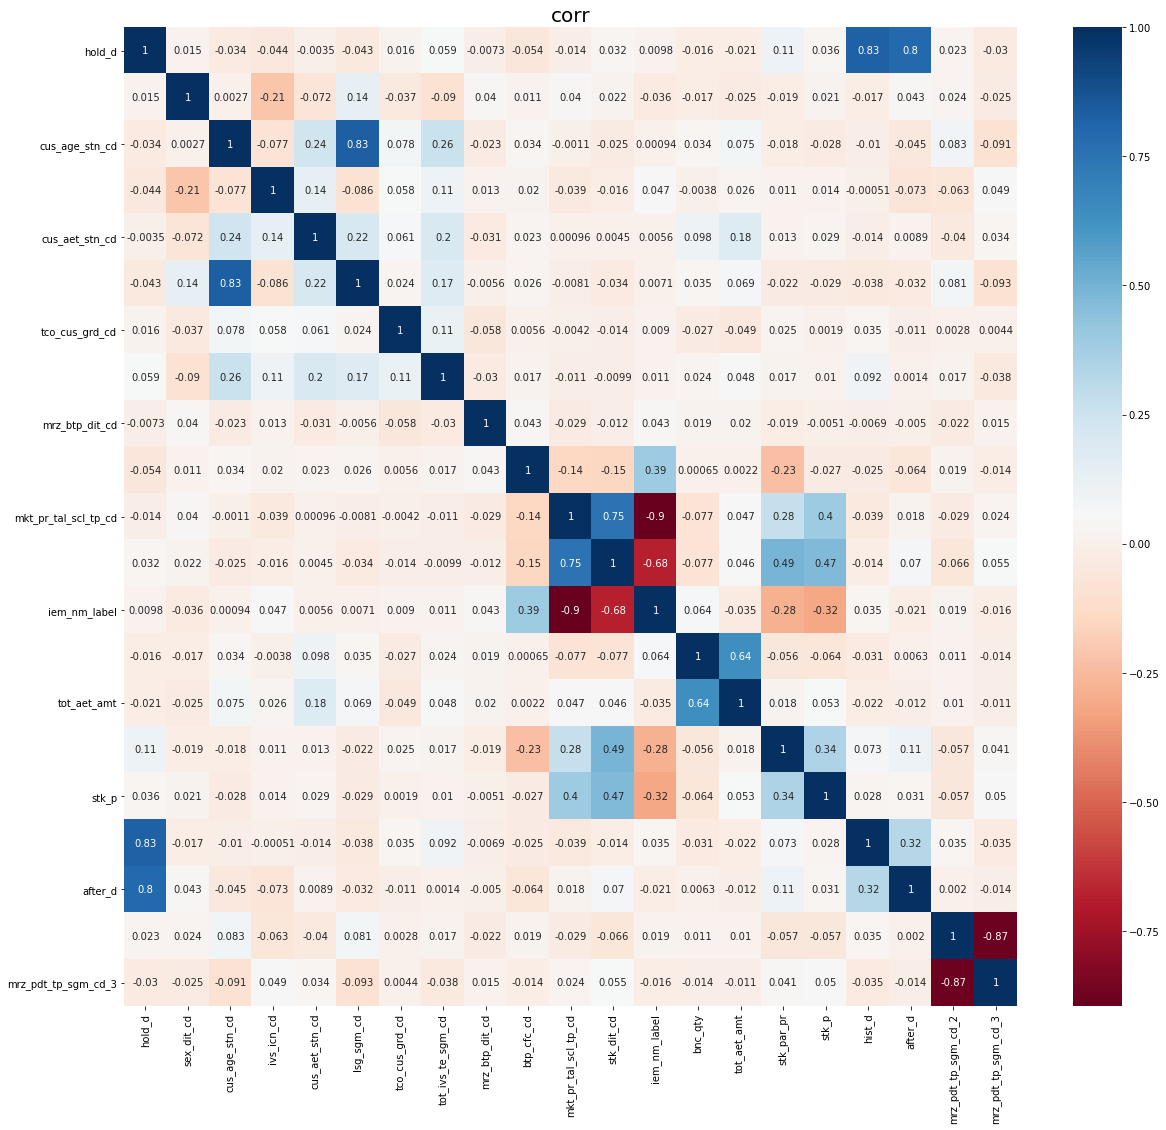

In [11]:
sns.heatmap(data=train_corr.corr(),annot=True,cmap='RdBu')
fig=plt.gcf()
fig.set_size_inches(20,18)
plt.title('corr',fontsize=20)
plt.show()

### after_d의 다른 변수와의 상관관계를 보면 액면가와 hist_d가 상당히 높은 상관관계를 가짐을 알 수 있다

## test도 한번 상관관계를 본다( train과 비슷한 성향을 가지는지 보기위해서) -> 귀찮으니 다음에

In [12]:
train

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tco_cus_grd_cd,...,stk_dit_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,hist_d,after_d,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3
0,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20190424,174,0,4,5,5,3,4,...,0,1099,1670.0,9769500.0,5000.0,5850.0,170,4,1,0
1,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20190924,71,0,4,5,5,3,4,...,0,2098,7999.0,19517560.0,500.0,2440.0,67,4,1,0
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A042510,20190524,241,0,6,4,4,5,2,...,0,1931,1100.0,3789500.0,500.0,3445.0,150,91,1,0
3,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A001045,20190617,164,0,6,4,4,5,2,...,0,2311,23.0,1271900.0,5000.0,55300.0,135,29,1,0
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A166090,20191030,85,0,6,4,4,5,2,...,1,349,200.0,3400000.0,500.0,17000.0,43,42,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16033,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,A067630,20191030,72,1,2,0,6,2,2,...,1,107,852.0,29394000.0,500.0,34500.0,43,29,1,0
16034,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,A028300,20191028,123,1,2,0,6,2,2,...,1,151,264.0,34584000.0,500.0,131000.0,45,78,1,0
16035,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A100700,20191120,38,0,6,0,5,5,3,...,0,556,20.0,65600.0,100.0,3280.0,28,10,1,0
16036,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A026960,20190701,262,0,6,0,5,5,3,...,2,59,2.0,38100.0,500.0,19050.0,125,137,1,0


# Modeling
## hold_d가 아닌 after_d를 target으로 설정한다.
## hist_d와 after_d의 관계를 알아내는 것이 주 목적이다.

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsRegressor # k-최근접 이웃 회귀 #분류대신 값을 예측
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [14]:
train_X=train.drop(['act_id','iem_cd','byn_dt','hold_d','after_d'],axis=1)
train_Y=train['hold_d']

ms = MinMaxScaler()
X_train_m = pd.DataFrame(ms.fit_transform(train_X))


# 개별 모델 성능(RMSE)확인


In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsRegressor # k-최근접 이웃 회귀 #분류대신 값을 예측
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


knn_model = KNeighborsRegressor()
svr_model = SVR()
lr_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = LGBMRegressor()

y=train_Y
X=train_X

cross_score_knn = cross_val_score(knn_model, X, y, scoring='neg_mean_squared_error', cv=5)
cross_score_lr = cross_val_score(lr_model, X, y, scoring='neg_mean_squared_error', cv=5)
cross_score_svr = cross_val_score(svr_model, X, y, scoring='neg_mean_squared_error', cv=5)
cross_score_rf = cross_val_score(rf_model, X, y, scoring='neg_mean_squared_error', cv=5)
cross_score_lgb = cross_val_score(lgb_model, X, y, scoring='neg_mean_squared_error', cv=5)


r_score_knn = np.sqrt(-cross_score_knn)
r_score_lr = np.sqrt(-cross_score_lr)
r_score_svr = np.sqrt(-cross_score_svr)
r_score_rf = np.sqrt(-cross_score_rf)
r_score_lgb = np.sqrt(-cross_score_lgb)

print("KNN score :",r_score_knn, " / KNN mean score", r_score_knn.mean())
print("LR score :",r_score_lr, " / LR mean score", r_score_lr.mean()) 
print("SVR score :",r_score_svr, " / SVR mean score", r_score_svr.mean())
print("RF score :",r_score_rf, " / RF mean score", r_score_rf.mean())
print("LGB score :",r_score_lgb, " / LGB mean score", r_score_lgb.mean())

KNN score : [117.9094129  119.62378831 125.57595843 124.28582495 110.57948907]  / KNN mean score 119.59489473023514
LR score : [58.72355191 59.55959077 62.62867006 61.80131072 61.50970036]  / LR mean score 60.844564764589066
SVR score : [114.46539591 112.30185649 121.75490559 120.06036043  95.20229421]  / SVR mean score 112.75696252433298
RF score : [60.96868081 60.46351388 63.80691763 62.7276362  61.7559115 ]  / RF mean score 61.9445320054168
LGB score : [59.19004431 59.12221749 62.65839885 62.7365474  61.12620239]  / LGB mean score 60.966682086667085


## 선형회귀와 LGB가 비슷하게 나온다. 
### 앞서 나온 LGB의 RMSE 59.0은 하이퍼 파라미터로 인한 것으로 판단된다.
### LGB를 쓰는 것이 바르다고 할 수 있으나, train 과 test의 성격이 달라서 상당히 보편적인 모델링을 해야한다고 고려하여 선형회귀를 사용한다

In [16]:
lr_model = LinearRegression()

model = lr_model.fit(train_X,train_Y)

In [123]:
'''# 데이터 분리
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, train_test_split
#모델
from lightgbm import LGBMRegressor

y=Y
X=X

train_x,val_x,train_y,val_y=train_test_split(X,y,test_size=0.25,random_state=1)

model = LGBMRegressor(objective= "regression",
                          max_depth= 20,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)

model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=100,
              verbose=500)
              '''

'# 데이터 분리\nfrom sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, train_test_split\n#모델\nfrom lightgbm import LGBMRegressor\n\ny=Y\nX=X\n\ntrain_x,val_x,train_y,val_y=train_test_split(X,y,test_size=0.25,random_state=1)\n\nmodel = LGBMRegressor(objective= "regression",\n                          max_depth= 20,\n                          n_estimators= 2000,\n                          learning_rate= 0.01,\n                          num_leaves = 31)\n\nmodel.fit(train_x, train_y,\n              eval_set=[(val_x, val_y)],\n              eval_metric=["rmse"],\n              early_stopping_rounds=100,\n              verbose=500)\n              '

In [124]:
'''pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,color='#ddff11')
#fig=plt.gcf()
#fig.set_size_inches(30,28)
plt.show()'''

"pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,color='#ddff11')\n#fig=plt.gcf()\n#fig.set_size_inches(30,28)\nplt.show()"

In [17]:
model

LinearRegression()

# test로 모델링을 실시한다.
### 기존과 동일하게 2020년에 구매한 train은 따로 예측을 실시한다

In [18]:
test

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,...,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,0,9,3,2,...,4,3,2,28,300.0,3945000.0,5000.0,13150.0,1,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,0,9,3,2,...,10,1,0,1582,198.0,2524500.0,500.0,12750.0,1,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,0,9,3,2,...,13,2,0,654,138.0,4291800.0,500.0,31100.0,1,0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,0,9,3,2,...,13,1,0,2066,2972.0,6716720.0,500.0,2260.0,1,0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,0,9,3,2,...,13,3,1,169,10.0,464500.0,100.0,46450.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,0,6,0,5,...,2,3,2,10,1.0,198500.0,500.0,198500.0,1,0
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,0,6,0,5,...,2,0,0,2322,50.0,372000.0,5000.0,7440.0,1,0
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,0,4,4,2,...,14,1,0,2269,75057.0,3677793.0,100.0,49.0,1,0
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,0,4,4,2,...,8,2,0,469,96.0,11424000.0,2500.0,119000.0,1,0


In [19]:
test.columns

Index(['act_id', 'iem_cd', 'byn_dt', 'hist_d', 'submit_id', 'hold_d',
       'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd',
       'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd',
       'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'iem_nm_label',
       'bnc_qty', 'tot_aet_amt', 'stk_par_pr', 'stk_p', 'mrz_pdt_tp_sgm_cd_2',
       'mrz_pdt_tp_sgm_cd_3'],
      dtype='object')

In [20]:
test_2020=test[test['byn_dt']>20200000]
test_2019=test[test['byn_dt']<20200000]

test_2020_sub=test_2020[['submit_id','hold_d']]

test_2020_X=test_2020.drop(['act_id','iem_cd','byn_dt','submit_id','hold_d'],axis=1)
test_2020_X

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3
0,153,0,9,3,2,9,5,5,8,4,3,2,28,300.0,3945000.0,5000.0,13150.0,1,0
2,139,0,9,3,2,9,5,5,8,13,2,0,654,138.0,4291800.0,500.0,31100.0,1,0
3,236,0,9,3,2,9,5,5,8,13,1,0,2066,2972.0,6716720.0,500.0,2260.0,1,0
4,9,0,9,3,2,9,5,5,8,13,3,1,169,10.0,464500.0,100.0,46450.0,1,0
5,93,0,6,0,3,5,5,6,9,13,1,0,1860,60.0,186900.0,500.0,3115.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70590,62,0,6,0,5,5,3,5,2,14,2,0,695,9.0,531000.0,5000.0,59000.0,1,0
70591,23,0,6,0,5,5,3,5,2,2,3,2,10,1.0,198500.0,500.0,198500.0,1,0
70592,103,0,6,0,5,5,3,5,2,2,0,0,2322,50.0,372000.0,5000.0,7440.0,1,0
70594,11,0,4,4,2,3,4,3,8,8,2,0,469,96.0,11424000.0,2500.0,119000.0,1,0


In [22]:
# train 이랑 순서를 column 순서를 맞춰줌
tt_test_2020=test_2020_X[['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd',
       'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd',
       'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'iem_nm_label',
       'bnc_qty', 'tot_aet_amt', 'stk_par_pr', 'stk_p', 'hist_d',
       'mrz_pdt_tp_sgm_cd_2', 'mrz_pdt_tp_sgm_cd_3']]
X_test_m = pd.DataFrame(ms.transform(tt_test_2020))


predict=model.predict(tt_test_2020)
predict
# after_d에 hist_d를 더해줘서 predict를 hold_d 예측치로 만든다


array([250.68716885, 201.5610415 , 337.87680717, ..., 202.86556241,
        46.3619735 ,  47.84891166])

In [23]:
# hold_d의 범주안으로 맞춰준다
test_2020['pred']=predict
test_2020['min_d']=test_2020['hist_d']+1
test_2020['max_d']=test_2020['hist_d']+146

maxvs=test_2020[['pred','max_d']]
maxvs['pred_max']=maxvs.min(axis=1)

minvs=pd.DataFrame(test_2020['min_d'])
minvs['pred_max']=maxvs['pred_max']
test_2020['pred_final']=minvs.max(axis=1)

test_2020

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,...,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3,pred,min_d,max_d,pred_final
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,0,9,3,2,...,300.0,3945000.0,5000.0,13150.0,1,0,250.687169,154,299,250.687169
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,0,9,3,2,...,138.0,4291800.0,500.0,31100.0,1,0,201.561041,140,285,201.561041
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,0,9,3,2,...,2972.0,6716720.0,500.0,2260.0,1,0,337.876807,237,382,337.876807
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,0,9,3,2,...,10.0,464500.0,100.0,46450.0,1,0,36.973325,10,155,36.973325
5,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A050110,20200814,93,IDX00006,0,0,6,0,3,...,60.0,186900.0,500.0,3115.0,1,0,161.233880,94,239,161.233880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70590,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005180,20200929,62,IDX70591,0,0,6,0,5,...,9.0,531000.0,5000.0,59000.0,1,0,129.009530,63,208,129.009530
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,0,6,0,5,...,1.0,198500.0,500.0,198500.0,1,0,88.022491,24,169,88.022491
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,0,6,0,5,...,50.0,372000.0,5000.0,7440.0,1,0,202.865562,104,249,202.865562
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,0,4,4,2,...,96.0,11424000.0,2500.0,119000.0,1,0,46.361974,12,157,46.361974


In [24]:
test_2020_sub['hold_d']=test_2020['pred_final']
test_2020_sub

,submit_id,hold_d
0,IDX00001,250.687169
2,IDX00003,201.561041
3,IDX00004,337.876807
4,IDX00005,36.973325
5,IDX00006,161.233880
...,...,...
70590,IDX70591,129.009530
70591,IDX70592,88.022491
70592,IDX70593,202.865562
70594,IDX70595,46.361974


## test_201x 같은 경우 기존의 baseline의 예측치를 그대로 사용한다
## test_2020과 test_201x를 결합한다

In [25]:
sub_org=pd.read_csv("sub_basee.csv")
sub_org

,submit_id,hold_d
0,IDX00001,255.0
1,IDX00002,481.0
2,IDX00003,232.0
3,IDX00004,382.0
4,IDX00005,15.0
...,...,...
70591,IDX70592,39.0
70592,IDX70593,172.0
70593,IDX70594,863.0
70594,IDX70595,19.0


In [149]:
sub=pd.merge(sub_org,test_2020_sub,how="left",on=['submit_id'])
sub_0=sub.fillna(0)
sub_0

,submit_id,hold_d_x,hold_d_y
0,IDX00001,255.0,250.687169
1,IDX00002,481.0,0.000000
2,IDX00003,232.0,201.561041
3,IDX00004,382.0,337.876807
4,IDX00005,15.0,36.973325
...,...,...,...
70591,IDX70592,39.0,88.022491
70592,IDX70593,172.0,202.865562
70593,IDX70594,863.0,0.000000
70594,IDX70595,19.0,46.361973


In [150]:
sub_2020=sub_0[sub_0['hold_d_y']>0]
sub_201x=sub_0[sub_0['hold_d_y']==0]

sub_2020['pred']=sub_2020['hold_d_y']
sub_201x['pred']=sub_201x['hold_d_x']

In [151]:
sub_2020

,submit_id,hold_d_x,hold_d_y,pred
0,IDX00001,255.0,250.687169,250.687169
2,IDX00003,232.0,201.561041,201.561041
3,IDX00004,382.0,337.876807,337.876807
4,IDX00005,15.0,36.973325,36.973325
5,IDX00006,155.0,161.233880,161.233880
...,...,...,...,...
70590,IDX70591,104.0,129.009530,129.009530
70591,IDX70592,39.0,88.022491,88.022491
70592,IDX70593,172.0,202.865562,202.865562
70594,IDX70595,19.0,46.361973,46.361973


In [152]:
sub_201x

,submit_id,hold_d_x,hold_d_y,pred
1,IDX00002,481.0,0.0,481.0
7,IDX00008,866.0,0.0,866.0
9,IDX00010,656.0,0.0,656.0
11,IDX00012,1228.0,0.0,1228.0
12,IDX00013,613.0,0.0,613.0
...,...,...,...,...
64827,IDX64828,511.0,0.0,511.0
70580,IDX70581,1228.0,0.0,1228.0
70587,IDX70588,433.0,0.0,433.0
70588,IDX70589,503.0,0.0,503.0


In [153]:
sub_final=pd.concat([sub_2020,sub_201x])
sub_final=sub_final[['submit_id','pred']]
sub_final

,submit_id,pred
0,IDX00001,250.687169
2,IDX00003,201.561041
3,IDX00004,337.876807
4,IDX00005,36.973325
5,IDX00006,161.233880
...,...,...
64827,IDX64828,511.000000
70580,IDX70581,1228.000000
70587,IDX70588,433.000000
70588,IDX70589,503.000000


In [154]:
ss=pd.merge(sub_0,sub_final,how="left",on=['submit_id'])
ss

,submit_id,hold_d_x,hold_d_y,pred
0,IDX00001,255.0,250.687169,250.687169
1,IDX00002,481.0,0.000000,481.000000
2,IDX00003,232.0,201.561041,201.561041
3,IDX00004,382.0,337.876807,337.876807
4,IDX00005,15.0,36.973325,36.973325
...,...,...,...,...
70591,IDX70592,39.0,88.022491,88.022491
70592,IDX70593,172.0,202.865562,202.865562
70593,IDX70594,863.0,0.000000,863.000000
70594,IDX70595,19.0,46.361973,46.361973


In [155]:
ss.rename(columns={"pred":"hold_d"},inplace=True)

sub_0910_03=ss[['submit_id','hold_d']]
sub_0910_03

,submit_id,hold_d
0,IDX00001,250.687169
1,IDX00002,481.000000
2,IDX00003,201.561041
3,IDX00004,337.876807
4,IDX00005,36.973325
...,...,...
70591,IDX70592,88.022491
70592,IDX70593,202.865562
70593,IDX70594,863.000000
70594,IDX70595,46.361973


In [156]:
sub_0910_03.to_csv('sub_0910_lr.csv',index=False)

## 기존의 전체 train을 고려한 model로 예측한 sub에서 2020년에 구매한 test의 예측 값만 바꿔준다